# The Zangellini Similarity

In [1]:
# Imports
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from quantum_systems import OneDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.integrators import GaussIntegrator
from tdhf import HartreeFock
from coupled_cluster.mix import DIIS

In [2]:
# Major Lazer
class LaserPulse:
    def __init__(self, laser_frequency=2, laser_strength=1):
        self.laser_frequency = laser_frequency
        self.laser_strength = laser_strength

    def __call__(self, t):
        return self.laser_strength * np.sin(self.laser_frequency * t)

In [3]:
# The Zanghellini system
n = 2
l = 12
length = 10
num_grid_points = 400
omega = 0.25
laser_frequency = 8 * omega
laser_strength = 1

zanghellini = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)
zanghellini.setup_system()
major_laser = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini.set_time_evolution_operator(major_laser)

In [4]:
# hf_zanghellini = HartreeFock(zanghellini, verbose=True)
# C = hf_zanghellini.scf(tolerance=1e-6)
# zanghellini.change_basis(C)
zanghellini.change_to_hf_basis(tolerance=1e-6)

In [5]:
tdccsd_zanghellini = TDCCSD(zanghellini, 
                            np=np, 
                            verbose=True, 
                            mixer=DIIS, 
                            integrator=GaussIntegrator(np=np, eps=1e-10))
tdccsd_zanghellini.compute_ground_state(t_kwargs=dict(num_vecs=5), l_kwargs=dict(num_vecs=5))
print(f"HF->CCSD ground state energy: {tdccsd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [0.1668522054549599, 0.6947037652014731]
Iteration: 1	Residuals (t): [0.17300833356955708, 0.5250697820459913]
Iteration: 2	Residuals (t): [0.00701803677648449, 0.15626205156286593]
Iteration: 3	Residuals (t): [0.029866397104634058, 0.04966511414214478]
Iteration: 4	Residuals (t): [0.02438437019973683, 0.12413839797089084]
Iteration: 5	Residuals (t): [0.06468967192785935, 0.030131406211840184]
Iteration: 6	Residuals (t): [0.006230697405513582, 0.043026933237194455]
Iteration: 7	Residuals (t): [0.01600224973747707, 0.036623233031912776]
Iteration: 8	Residuals (t): [0.013353498503456062, 0.015323103941999724]
Iteration: 9	Residuals (t): [0.0015137397133631663, 0.016660862214469205]
Iteration: 10	Residuals (t): [0.0017592982022362506, 0.016005691631739347]
Iteration: 11	Residuals (t): [0.0002495559184744392, 0.008727160355665918]
Iteration: 12	Residuals (t): [0.0037978154959978838, 0.0060937115768151156]
Iteration: 13	Residuals (t): [0.0034915099869735023, 0.00

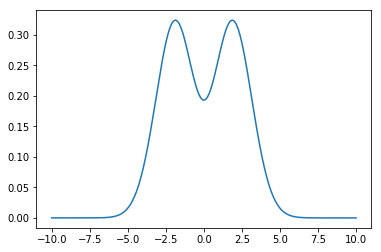

In [6]:
rho = tdccsd_zanghellini.compute_ground_state_particle_density()
plt.plot(zanghellini.grid, rho.real)
plt.show()

In [7]:
tdccsd_zanghellini.set_initial_conditions()

In [8]:
num_time_steps = 1001
time_points = np.linspace(0, 10, num_time_steps)
psi_overlap = np.zeros(num_time_steps)
td_energies = np.zeros(num_time_steps)

psi_overlap[0] = tdccsd_zanghellini.compute_time_dependent_overlap().real
td_energies[0] = tdccsd_zanghellini.compute_energy().real

In [9]:
for i, amp in tqdm_notebook(enumerate(tdccsd_zanghellini.solve(time_points)), total=num_time_steps-1):
    psi_overlap[i + 1] = tdccsd_zanghellini.compute_time_dependent_overlap().real
    td_energies[i + 1] = tdccsd_zanghellini.compute_energy().real

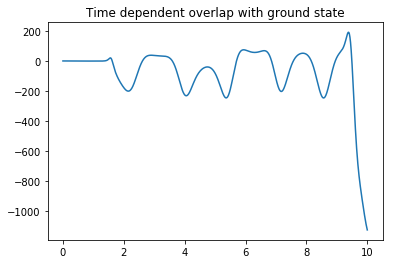

In [10]:
plt.plot(time_points, psi_overlap)
plt.title("Time dependent overlap with ground state")
plt.show()

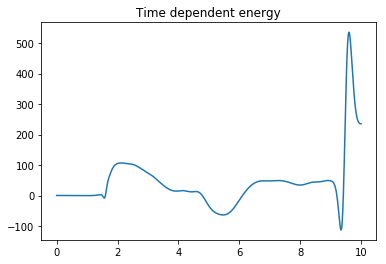

In [11]:
plt.plot(time_points, td_energies)
plt.title("Time dependent energy")
plt.show()